# SWOT



In [1]:
import geopandas as gpd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import contextily as ctx

## Select the reservoir

In [2]:
start_date = '2022-01-01'
end_date = '2025-10-30'

RESERVOIR = 1

buffer_amt = 1000 # meters

swot_save_dir = Path('/tiger1/pdas47/resorr-swot/data/swot/raw')

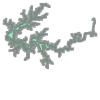

In [16]:
RESERVOIRS = gpd.read_file(Path('/tiger1/pdas47/resorr-swot/data/cumberland-reservoirs/03-cumberland-reservoirs.geojson'))

selected_reservoirs = RESERVOIRS['id'].tolist()
res_names = RESERVOIRS[['id', 'name']].set_index('id').to_dict()['name']

RESERVOIR_NAME = res_names[RESERVOIR]
RESERVOIR_GDF = RESERVOIRS[RESERVOIRS['id'] == RESERVOIR]
RESERVOIR_GEOMETRY = RESERVOIR_GDF.geometry.iloc[0]

RESERVOIR_GEOMETRY

In [5]:
gd_track_fn = Path('/tiger1/pdas47/resorr-swot/data/swot_orbit/swot_orbit.geojson')
gd_track = gpd.read_file(gd_track_fn)

Text(0.5, 1.0, 'Laurel_Dam\nBuffered: 1000 m')

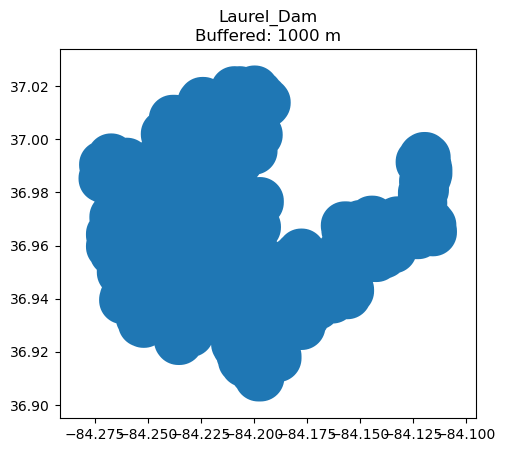

In [7]:
after_buffer = RESERVOIR_GDF.crs
for_buffer = RESERVOIR_GDF.estimate_utm_crs()

RESERVOIR_BUFFERED_GDF = RESERVOIR_GDF.to_crs(for_buffer).buffer(buffer_amt).to_crs(after_buffer)
RESERVOIR_BUFFERED_GDF.plot()
plt.title(f"{RESERVOIR_NAME}\nBuffered: {buffer_amt} m")

/tiger1/pdas47/resorr-swot/.env/lib/python3.13/site-packages/geopandas/geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tiger1/pdas47/resorr-swot/.env/lib/python3.13/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/tiger1/pdas47/resorr-swot/.env/lib/python3.13/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(y))


/tiger1/pdas47/resorr-swot/.env/lib/python3.13/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/tiger1/pdas47/resorr-swot/.env/lib/python3.13/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


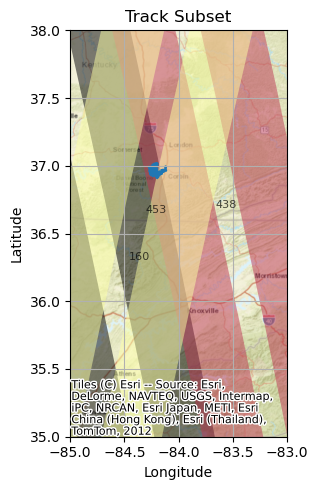

In [8]:
gd_track_subset = gd_track[gd_track.intersects(RESERVOIR_BUFFERED_GDF.geometry.values[0])]

roi_gdf = gpd.GeoDataFrame(RESERVOIR_BUFFERED_GDF).rename({0: 'geometry'}, axis=1)
roi_gdf = roi_gdf.set_geometry('geometry')
roi_gdf['name'] = RESERVOIR_NAME

cmap = mpl.colormaps['inferno']
gd_track_subset['color'] = [mpl.colors.rgb2hex(cmap(i)) for i in np.linspace(0, 1, len(gd_track_subset.groupby('ID_PASS')))]

# Plot base map (OpenStreetMap tiles not supported directly in pure matplotlib)
# You would need contextily or cartopy for background tiles, but skipping here for simplicity

fig, ax = plt.subplots(figsize=(5, 5))

# Plot the geometries
gd_track_subset.plot(
    ax=ax,
    color=gd_track_subset['color'],
    alpha=0.5,
    linewidth=2
)

# Set bounds
xmin = int(RESERVOIR_BUFFERED_GDF.total_bounds[0]) - 1
xmax = int(RESERVOIR_BUFFERED_GDF.total_bounds[2]) + 1
ymin = int(RESERVOIR_BUFFERED_GDF.total_bounds[1]) - 1
ymax = int(RESERVOIR_BUFFERED_GDF.total_bounds[3]) + 1
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Optional: Label with ID_PASS
for feature in gd_track_subset.iterfeatures():
    feature['id'] = int(feature['id'])
    row = gpd.GeoDataFrame.from_features([feature])
    id_pass = row['ID_PASS'].values[0]

    row = row.clip_by_rect(xmin, ymin, xmax, ymax)
    x, y = row.geometry.centroid.x, row.geometry.centroid.y

    ax.text(x, y, str(id_pass), fontsize=8, alpha=0.7)


roi_gdf.plot(ax=ax)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap, crs=roi_gdf.crs)

# Improve aesthetics
ax.set_title("Track Subset")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

## SWOT KaRin
### determine pass number

In [10]:
matches = gd_track[gd_track.intersects(RESERVOIR_BUFFERED_GDF.to_crs('epsg:4326').iloc[0])]
pass_ids = list(matches.ID_PASS)
print(f'Passes: {pass_ids}')

Passes: [160, 438, 453]


In [11]:
# %load_ext autoreload
# %autoreload 2

### Download using podaac-data-downloader

In [12]:
import subprocess

# download passes
def download_swot_for_reservoir(roi, start_date, end_date, download_dir):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    download_dir = Path(download_dir)
    bounds = ",".join([f"{x:.3f}" for x in roi.total_bounds])

    podaac_cmd = [
        'podaac-data-downloader',
        '-c', 'SWOT_L2_HR_Raster_D',
        '-d', str(download_dir), 
        rf'-b="{bounds}"', # will download only the passes over the reservoir
        '-gr', '*_100m_*',
        '--start-date', pd.to_datetime(start_date).strftime('%Y-%m-%dT%XZ'),
        '--end-date', pd.to_datetime(end_date).strftime('%Y-%m-%dT%XZ'),
    ]

    res = subprocess.run(" ".join(podaac_cmd), shell=True)
    return res

download_swot_for_reservoir(RESERVOIR_BUFFERED_GDF, start_date, end_date, swot_save_dir)

[2025-06-21 20:38:09,443] {podaac_data_downloader.py:317} INFO - Found 29 total files to download
[2025-06-21 20:38:12,387] {podaac_data_downloader.py:358} INFO - 2025-06-21 20:38:12.387506 SUCCESS: https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_HR_Raster_D/SWOT_L2_HR_Raster_100m_UTM01W_N_x_x_x_034_267_137F_20250618T071152_20250618T071204_PID0_01.nc
[2025-06-21 20:38:12,566] {podaac_data_downloader.py:350} INFO - 2025-06-21 20:38:12.566526 SKIPPED: https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_HR_Raster_D/SWOT_L2_HR_Raster_100m_UTM60V_N_x_x_x_034_222_021F_20250616T155752_20250616T155813_PID0_01.nc
[2025-06-21 20:38:12,743] {podaac_data_downloader.py:350} INFO - 2025-06-21 20:38:12.743792 SKIPPED: https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_HR_Raster_D/SWOT_L2_HR_Raster_100m_UTM60W_N_x_x_x_034_194_019F_20250615T155641_20250615T155702_PID0_01.nc
[2025-06-21 20

CompletedProcess(args='podaac-data-downloader -c SWOT_L2_HR_Raster_D -d /tiger1/pdas47/resorr-swot/data/swot/raw -b="-84.283,36.901,-84.104,37.028" -gr *_100m_* --start-date 2022-01-01T00:00:00Z --end-date 2025-10-30T00:00:00Z', returncode=0)

### Download from from earthdata

The `download_swot_for_reservoir` function uses the podaac-subscriber utility. However this method fails to retrieve data pre-2024 even though the data exists and can be retrieved manually using Earthdata. I am not sure what is causing the issue for the podaac-subscriber utility. However, for now, let's use the Earthdata method to retrieve the data.

Obtain the download links using Earthdata. Save the list of download links in a txt file with the Reservoir ID as the name.

#### Downloading from Earthdata

Earthdata requires the spatial extent of the ROI for finding relevant datasets. export the currently selected reservoirs as a geojson file. The entire dataset is too large for earthdata. Also take the convex hull of the reservoirs to simplify the geometry.

In [13]:
# earthdata_polys = val_polys.copy()
# earthdata_polys['geometry'] = earthdata_polys.convex_hull

# earthdata_polys.to_file('/tiger1/pdas47/resorr-swot/data/gee_basin_params/selected-validation-reservoirs-grand-convex-hull-for-earthdata.geojson', driver='GeoJSON')

In [14]:
import subprocess

# links_fp = Path(f'/tiger1/pdas47/tmsosPP/data/swot/earthdata-links/{RESERVOIR}.txt')
links_fp = Path(f'/tiger1/pdas47/resorr-swot/data/swot/earthdata-links/cumberland.txt')
links = links_fp.read_text().split('\n')

for link in links:
    print(f'Downloading {link}')
    cmd = f'wget -nc -P {swot_save_dir.absolute()} {link}'
    res = subprocess.run(cmd.split(' '), capture_output=True, text=True)
    print("downloaded successfully" if res.returncode == 0 else "download failed")

downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded succe

downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded successfully
downloaded succe

### Create swot dataset

Pre-process the downloaded raster files to create a single dataset.

In [17]:
# from tmsswot.data import get_swot_id
import xarray as xr
# import easysnowdata
import geopandas as gpd
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
import geopandas as gpd
from pathlib import Path
import shutil
from rioxarray.crs import CRS
import subprocess
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
from rioxarray.exceptions import NoDataInBounds

def get_swot_id(
        id, 
        val_res_poly,
        start_date="2022-07-01", 
        end_date="2022-07-31", 
        buffer=2000, # m
        qual_mask_threshold=0.7,
        swot_dir = Path(f'/tiger1/pdas47/resorr-swot/data/swot'),
        gd_track_fn = Path('/tiger1/pdas47/resorr-swot/data/swot_orbit/swot_orbit.geojson'),
        download = False,
        dask_client=None,
        id_column_name='id'
    ):
    roi = val_res_poly.loc[val_res_poly[id_column_name]==id]
    buffered_roi = roi.to_crs(roi.estimate_utm_crs()).geometry.iloc[0].convex_hull.buffer(buffer)
    roi.crs = roi.estimate_utm_crs()
    roi.geometry = [buffered_roi]
    roi = roi.to_crs('epsg:4326')

    # download
    if download:
        download_swot_for_reservoir(roi, start_date, end_date, swot_dir)

    # determine swot pass numbers
    gd_track = gpd.read_file(gd_track_fn)

    matches = gd_track[gd_track.intersects(roi.iloc[0].geometry)]
    roi_track_intersect = matches.copy()
    roi_track_intersect['geometry'] = matches.intersection(roi.iloc[0].geometry)

    pass_ids = list(matches.ID_PASS)
    print("Matching pass ids: ", pass_ids)

    pass_id_l = []
    fns = []
    for pass_id in pass_ids:
        files = list(swot_dir.glob(f'*_{pass_id:03}_*'))
        pass_id_l.extend([pass_id]*len(files))
        fns.extend(files)

    # print(fns)
    
    fn_dates = []
    for fn in fns:
        try:
            fn_dates.append(fn.name.split('_')[13])
        except:
            fn_dates.append(pd.NaT)
    files_df = pd.DataFrame({
        'fn': fns, 'date': fn_dates, 'pass_id': pass_id_l
    })

    files_df['date'] = pd.to_datetime(files_df['date'])
    files_df = files_df[(files_df['date']>=start_date)&((files_df['date']<=end_date))]

    datas = []
    
    pbar = tqdm(total=files_df.shape[0])

    # def _process_row(idx, row):

    for idx, row in files_df.iterrows():
        # if dask_client is None:
        fn = Path(row['fn'])
        fn_date = row['date']
        pass_id = row['pass_id']

        data = xr.open_dataset(fn, decode_coords="all")
        date = pd.to_datetime(fn.name.split('_')[13]).date()

        data = data.assign_coords(
            reservoir=((id)),
            time=((pd.to_datetime(date))),
            pass_id = ((pass_id))
        )
        roi_track_intersect_pass = roi_track_intersect[roi_track_intersect.ID_PASS==pass_id]
        projection = roi.estimate_utm_crs()
        roi = roi.to_crs(projection)
        roi_track_intersect_pass = roi_track_intersect_pass.to_crs(projection)
        data = data.rio.write_crs(projection)
        try:
            data = data[[
                'water_area', 'water_area_qual', 
                'water_frac', 'water_frac_uncert', 
                'wse', 'wse_uncert', 'wse_qual', 'time'
            ]].rio.clip(roi_track_intersect_pass.geometry.values, crs=projection, drop=True)
            datas.append(data)

            pbar.update(1)
        except NoDataInBounds as e:
            pbar.update(1)
            pass
        #         _process_row(idx, row)
        # else:
        #     args = [(idx, row) for idx, row in files_df.iterrows()]
        #     # print(args)
        #     futures = dask_client.map(_process_row, args)

        # if futures != None:
        #     datas = dask_client.gather(futures)        
        
    try:
        data = xr.concat(datas, dim='time')
        # the data is now concatenated, each individual raster file with the necessary variables in one dataset.
        # however, we want to reduce the data by combining all the data slices associated with a single day. Can be done by a groupby operation.
        
        def determine_passes(gp):
            # there can be multiple passes in a single day. 
            # to store this info, a separate groupby operation has to be done where the passes are concatenated as strings, 
            # apart from the mean operation that is applied over other varriables.
            # print(gp, gp.pass_ids.values)
            str_passes = ','.join([str(val) for val in np.unique(gp.pass_id.values)])

            return xr.DataArray(str_passes)
        
        # pass_ids = data[['time', 'pass_ids']].groupby('time')#.map(determine_passes).rename('pass_ids')
        pass_ids = []
        for i, gp in data[['time', 'pass_id']].groupby('time'):
            # print(gp)
            pass_ids.append(determine_passes(gp))
        pass_ids = xr.concat(pass_ids, dim='time')

        # apply mean over all other data variables.
        data = data.groupby('time').mean(dim='time')
        data['pass_ids'] = pass_ids
        # data['time'] = pass_ids['time']

        data = data.chunk(chunks={
            'time': 30,
            'x': 4096,
            'y': 4096
        })

        return data
    except Exception as e:
        print(e)
        return None

swot_dir = Path(f'/tiger1/pdas47/resorr-swot/data/swot/raw')
gd_track_fn = Path('/tiger1/pdas47/resorr-swot/data/swot_orbit/swot_orbit.geojson')

swot_ds = get_swot_id(
    RESERVOIR, RESERVOIRS, 
    start_date, end_date, download=False,
    swot_dir=swot_dir, gd_track_fn=gd_track_fn,
    dask_client = None
)
swot_ds

/tiger1/pdas47/resorr-swot/.env/lib/python3.13/site-packages/geopandas/geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Matching pass ids:  [160, 438, 453]


  0%|          | 0/171 [00:00<?, ?it/s]

<xarray.Dataset> Size: 49MB
Dimensions:            (time: 60, y: 161, x: 180)
Coordinates:
  * x                  (x) float64 1kB 7.409e+05 7.41e+05 ... 7.588e+05
  * y                  (y) float64 1kB 4.087e+06 4.087e+06 ... 4.103e+06
    reservoir          int64 8B 1
    spatial_ref        int64 8B 0
    crs                int64 8B 0
  * time               (time) datetime64[ns] 480B 2023-08-06 ... 2025-06-14
Data variables:
    water_area         (time, y, x) float32 7MB dask.array<chunksize=(30, 161, 180), meta=np.ndarray>
    water_area_qual    (time, y, x) float32 7MB dask.array<chunksize=(30, 161, 180), meta=np.ndarray>
    water_frac         (time, y, x) float32 7MB dask.array<chunksize=(30, 161, 180), meta=np.ndarray>
    water_frac_uncert  (time, y, x) float32 7MB dask.array<chunksize=(30, 161, 180), meta=np.ndarray>
    wse                (time, y, x) float32 7MB dask.array<chunksize=(30, 161, 180), meta=np.ndarray>
    wse_uncert         (time, y, x) float32 7MB dask.array<chunksize=(30, 161, 180), meta=np.ndarray>
    wse_qual           (time, y, x) float32 7MB dask.array<chunksize=(30, 161, 180), meta=np.ndarray>
    pass_ids           (time) <U3 720B dask.array<chunksize=(30,), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2024-07-19T22:59:29Z : Creation
    platform:                      SWOT
    references:                    V1.2.1
    ...                            ...
    x_min:                         611700.0
    x_max:                         766300.0
    y_min:                         4024000.0
    y_max:                         4178600.0
    institution:                   CNES
    product_version:               01

In [18]:
swot_ds['pass_ids'].values

array(['453', '453', '160', '453', '453', '160', '453', '453', '160',
       '453', '160', '453', '160', '453', '160', '453', '160', '453',
       '160', '160', '453', '160', '453', '160', '453', '160', '453',
       '160', '453', '160', '453', '453', '160', '453', '160', '453',
       '160', '453', '160', '453', '160', '453', '160', '453', '160',
       '453', '160', '453', '160', '453', '160', '453', '160', '453',
       '160', '453', '453', '160', '453', '160'], dtype='<U3')

### Plot

In [19]:
# ds = swot_ds

# ds['wse'].hvplot(
#     x='x', y='y', rasterize=True, aspect='equal', clim=(80, 100) # , geo=True, # crs=ds.rio.crs
# ).opts(
#     title='Water Surface Elevation (m)'
# ) + ds['wse_uncert'].hvplot(
#     x='x', y='y', rasterize=True, clim=(0, 1), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=ds.rio.crs
# ).opts(
#     title='Water Surface Elevation Uncertainty (m)'
# )

In [20]:
# swot_ds['water_frac'].hvplot(
#     x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1) # , geo=True, # crs=swot_ds.rio.crs
# ).opts(
#     title='Water Fraction'
# ) + swot_ds['water_frac_uncert'].hvplot(
#     x='x', y='y', rasterize=True, clim=(0, 1), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=swot_ds.rio.crs
# ).opts(
#     title='Water Fraction Uncertainty'
# )

In [21]:
# swot_ds['water_area'].hvplot(
#     x='x', y='y', rasterize=True, aspect='equal', clim=(0, 1e4) # , geo=True, # crs=swot_ds.rio.crs
# ).opts(
#     title='Water Area'
# ) + swot_ds['water_area_qual'].hvplot(
#     x='x', y='y', rasterize=True, clim=(0, 3), aspect='equal', cmap='RdYlBu_r' #  geo=True, crs=swot_ds.rio.crs
# ).opts(
#     title='Water Area Quality (0=nominal,1=suspect,2=degraded,3=bad)'
# )

### save

In [23]:
save_fp = Path(f'/tiger1/pdas47/resorr-swot/data/swot/swot_karin_intermediate/{RESERVOIR}.nc')
swot_ds.to_netcdf(save_fp)
print(f'saved at {save_fp}')

saved at /tiger1/pdas47/resorr-swot/data/swot/swot_karin_intermediate/1.nc


## SWOT NADIR

### download

In [21]:
gd_track_nadir_fn = Path('/tiger1/pdas47/resorr-swot/data/swot_orbit/nadir/swot_science_orbit_sept2015-v2_nadir.shp')
gd_track_nadir = gpd.read_file(gd_track_nadir_fn)
gd_track_nadir.head(2)

,ID_PASS,START_TIME,geometry
0,1,Day 01 00:00:00,"LINESTRING (-75.40128 -77.54325, -67.74948 -77..."
1,2,Day 01 00:51:30,"LINESTRING (84.56135 77.66162, 92.5227 77.5155..."


In [23]:
gd_track_nadir_subset = gd_track_nadir[gd_track_nadir.intersects(buffered_roi.geometry.values[0])]
print(gd_track_nadir_subset)

assert len(gd_track_nadir_subset) != 0

gd_track_nadir_subset
roi_gdf = gpd.GeoDataFrame(buffered_roi).rename({0: 'geometry'}, axis=1)
roi_gdf = roi_gdf.set_geometry('geometry')
roi_gdf['name'] = RESERVOIR_NAME

# roi_hv = roi_gdf.hvplot(geo=True, alpha=0.8)

# plot_lims = buffered_roi.buffer(0.02).bounds
# minx = plot_lims.values[0][0]
# maxx = plot_lims.values[0][2]
# miny = plot_lims.values[0][1]
# maxy = plot_lims.values[0][3]

# roi.hvplot(color='gray') * gd_track_nadir_subset.hvplot(
#      by='ID_PASS', xlim=(minx, maxx), ylim=(miny, maxy), line_width=3, cmap='viridis'
# ).opts(aspect='equal', xlabel='longitude', ylabel='latitude', title=f"{RESERVOIR_NAME} - NADIR Passes")

     ID_PASS       START_TIME  \
293      203  Day 08 05:12:20   

                                              geometry  
293  LINESTRING (-177.12212 -77.66035, -174.46183 -...  


In [24]:
# matches = gd_track[gd_track.intersects(buffered_roi.to_crs('epsg:4326').iloc[0])]
nadir_matches = gd_track_nadir[gd_track_nadir.intersects(buffered_roi.to_crs('epsg:4326').iloc[0])]
# pass_ids = list(matches.ID_PASS)
nadir_pass_ids = list(nadir_matches.ID_PASS)
print(f'Nadir Passes: {nadir_pass_ids}')
print(nadir_matches.T)

Nadir Passes: [203]
                                                          293
ID_PASS                                                   203
START_TIME                                    Day 08 05:12:20
geometry    LINESTRING (-177.122124 -77.660354, -174.46182...


In [25]:
import subprocess

def download_swot_nadir_for_reservoir(roi, start_date, end_date, download_dir):
    # by bounds
    roi = roi.to_crs('epsg:4326')
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    download_dir = Path(download_dir)
    bounds = ",".join([f"{x:.3f}" for x in roi.total_bounds])

    print(bounds)
    podaac_cmd = [
        'podaac-data-downloader',
        '-c', 'SWOT_L2_NALT_IGDR_2.0',
        '-d', str(download_dir), 
        rf'-b="{bounds}"',
        '-gr="*_IPN_*"', # download native format nadir data from short time critical (other options: GPR, GPS)
        '--start-date', pd.to_datetime(start_date).strftime('%Y-%m-%dT%XZ'),
        '--end-date', pd.to_datetime(end_date).strftime('%Y-%m-%dT%XZ'),
    ]

    res = subprocess.run(" ".join(podaac_cmd), shell=True)
    return res

swot_nadir_save_dir = Path('/tiger1/pdas47/resorr-swot/data/swot/raw')
download_swot_nadir_for_reservoir(roi, start_date, end_date, swot_nadir_save_dir)

-88.234,36.584,-87.856,37.071


[2025-06-18 09:17:22,470] {podaac_data_downloader.py:317} INFO - Found 471 total files to download
[2025-06-18 09:17:25,674] {podaac_data_downloader.py:358} INFO - 2025-06-18 09:17:25.674231 SUCCESS: https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_NALT_IGDR_2.0/SWOT_IPN_2PfP032_220_20250505_203808_20250505_212934.nc
[2025-06-18 09:17:26,486] {podaac_data_downloader.py:358} INFO - 2025-06-18 09:17:26.486434 SUCCESS: https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_NALT_IGDR_2.0/SWOT_IPN_2PfP032_218_20250505_185514_20250505_194641.nc
[2025-06-18 09:17:27,883] {podaac_data_downloader.py:358} INFO - 2025-06-18 09:17:27.883675 SUCCESS: https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_NALT_IGDR_2.0/SWOT_IPN_2PfP032_215_20250505_162053_20250505_171220.nc
[2025-06-18 09:17:28,589] {podaac_data_downloader.py:358} INFO - 2025-06-18 09:17:28.589748 SUCCESS: https://archive.swot

CompletedProcess(args='podaac-data-downloader -c SWOT_L2_NALT_IGDR_2.0 -d /tiger1/pdas47/resorr-swot/data/swot/raw -b="-88.234,36.584,-87.856,37.071" -gr="*_IPN_*" --start-date 2022-01-01T00:00:00Z --end-date 2025-06-30T00:00:00Z', returncode=0)

In [ ]:
# def download_swot_nadir_passes(passes, start_date, end_date, download_dir):
#     start_date = pd.to_datetime(start_date)
#     end_date = pd.to_datetime(end_date)
#     download_dir = Path(download_dir)
#     results = []

#     for pass_id in passes:
#         podaac_cmd = [
#             'podaac-data-downloader',
#             '-c', 'SWOT_L2_NALT_IGDR_2.0',
#             '-d', str(download_dir), 
#             fr'-gr="*_IPN_*_{pass_id:03}_*"', # download native format nadir data (other options: GPR, GPS)
#             '--start-date', pd.to_datetime(start_date).strftime('%Y-%m-%dT%XZ'),
#             '--end-date', pd.to_datetime(end_date).strftime('%Y-%m-%dT%XZ'),
#         ]
#         res = subprocess.run(" ".join(podaac_cmd), shell=True)
#         results.append(res)
    
#     return results


# download_swot_nadir_passes(
#     nadir_pass_ids, start_date, end_date, swot_nadir_save_dir
# )

In [ ]:
# import subprocess

# links_fp = Path(f'/tiger1/pdas47/tmsosPP/data/swot_nadir_hlee/earthdata-links/{RESERVOIR}.txt')
# links = links_fp.read_text().split('\n')

# for link in links:
#     print(f'Downloading {link}')
#     cmd = f'wget -nc -P {swot_nadir_save_dir.absolute()} {link}'
#     res = subprocess.run(cmd.split(' '), capture_output=True, text=True)
#     print("downloaded successfully" if res.returncode == 0 else "download failed")

end of notebook.